In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import psycopg2
import contextily as cx
import matplotlib.pyplot as plt
import folium
import datetime
from datetime import date, timedelta
import locale

In [2]:
locale.setlocale(locale.LC_ALL, 'es-ES')

'es-ES'

In [3]:
dia_actual = date.today()
ayer = dia_actual - timedelta(days = 1)
ayer_str = ayer.strftime("%A %d de %B de %Y")
ayer_str

'martes 17 de enero de 2023'

In [4]:
con = psycopg2.connect(database= "ideam", user="user", password= "password",
    host = "localhost")
con_2 = psycopg2.connect(database= "tabla_manipulada", user="postgres", password= "password",
    host = "localhost")

In [5]:
fecha_anterior = ayer.strftime("%Y-%m-%d")
fecha_anterior

fecha_actual = dia_actual.strftime("%Y-%m-%d")

In [6]:
sql = f''' SELECT st.station_name, st.municipality, st.province, ad.id_stz, SUM(ad.raw_data) AS precipitacion, st.the_geom,
            ST_X(st.the_geom), ST_Y(st.the_geom)
            FROM data_radio.archive_data AS ad INNER JOIN configuration.stations AS st
                ON ad.id_stz = st.id_stz
            WHERE id_measure = 1
            AND ad.date_record BETWEEN '{fecha_anterior} 07:0:00.000'::timestamp AND  '{fecha_actual} 07:0:00.000'::timestamp
            GROUP BY ad.id_stz, st.station_name, st.municipality, st.province, ad.id_stz, st.the_geom
            HAVING SUM(ad.raw_data) between 0 AND 300 
            ORDER BY precipitacion DESC NULLS LAST; '''



In [7]:
departamentos = '''SELECT * FROM base.departamentos'''

In [8]:
df_departamentos = gpd.GeoDataFrame.from_postgis(departamentos, con_2, geom_col = 'geom', crs = "EPSG:4326")

In [9]:
estaciones = gpd.GeoDataFrame.from_postgis(sql, con, geom_col = 'the_geom', crs = "EPSG:4326")

<AxesSubplot:>

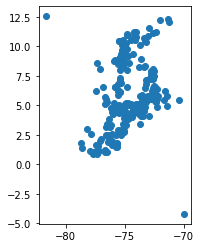

In [10]:
estaciones.plot()

In [11]:
estaciones.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
# ax = df.plot(figsize=(15, 15), alpha = 1, edgecolor='k', color = 'y', markersize = df["precipitacion"] * 10 )
# cx.add_basemap(ax, crs = df.crs, source=cx.providers.CartoDB.Voyager)

In [13]:

# colombia = df_departamentos.explore(m = estaciones, )
# df.explore(m = colombia, marker_kwds = {'radius': 4}, scheme = 'naturalbreaks', column = 'precipitacion', cmap = 'Set1', tiles="Open Street Map")

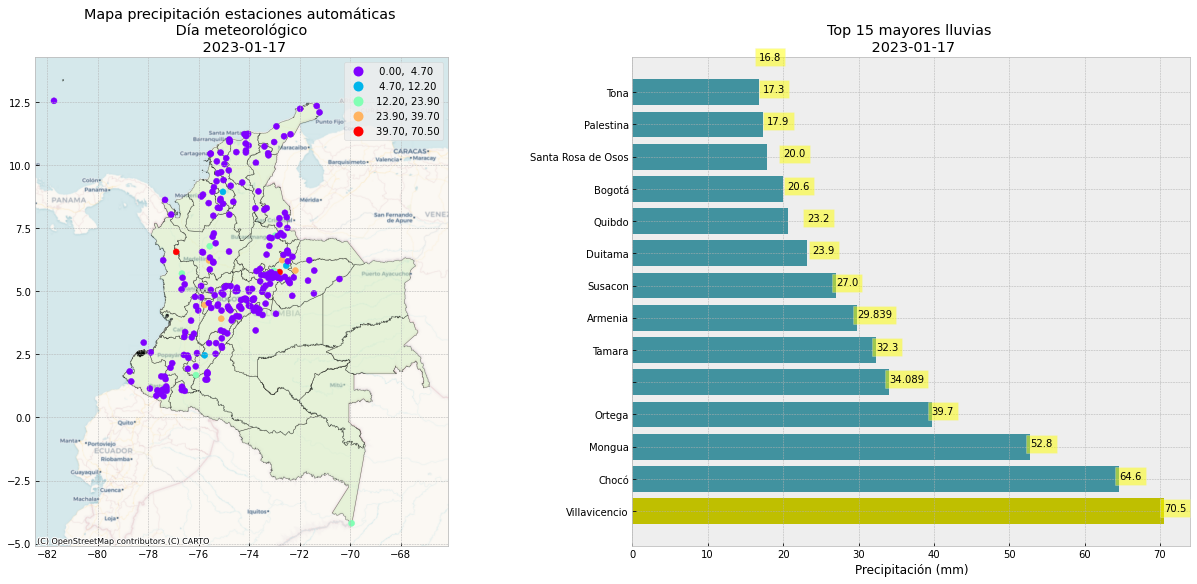

In [38]:
plt.style.use('bmh')
fig, (ax, ax2) = plt.subplots(figsize = (22, 9), nrows = 1, ncols = 2)

df_departamentos.plot(ax = ax, color = "#D3EEBF", edgecolor = "black", alpha = 0.5)
estaciones.plot(ax = ax, scheme = 'NaturalBreaks', column = 'precipitacion', cmap = 'rainbow', legend = True)
ax.set_title(f'Mapa precipitación estaciones automáticas \n Día meteorológico \n {fecha_anterior}')
ax2.set_title(f'Top 15 mayores lluvias \n {fecha_anterior}')
ax2.barh(estaciones['municipality'].head(15), estaciones['precipitacion'].head(15), color = ['y' if x == estaciones['precipitacion'].max() else '#41929F' for x in estaciones['precipitacion']])
for i in range(15):
    ax2.text(estaciones['precipitacion'].head(15)[i], i, estaciones['precipitacion'].head(15)[i], fontsize=10, color='black', bbox=dict(facecolor='yellow', alpha=0.5))
ax2.set_xlabel('Precipitación (mm)')
ax2.grid(visible = True)
cx.add_basemap(ax, crs = df_departamentos.crs, source=cx.providers.CartoDB.Voyager)

In [29]:
estaciones['precipitacion'].head(20)[14]

16.8

In [30]:
estaciones.head(14)

,station_name,municipality,province,id_stz,precipitacion,the_geom,st_x,st_y
0,PTE. ABADIA [35037100; MET; HID; LG; R; AO03; ...,Villavicencio,Meta,157,70.500,POINT (-73.63680 4.23552),-73.636800,4.235520
1,PR CHOCO: BELLAVISTA [11080010; CHO; MET; SUB;...,Chocó,Chocó,1652,64.600,POINT (-76.88810 6.55690),-76.888100,6.556900
2,MONGUA [2403500084; BOY; MET; ST; N; AO06; H8;...,Mongua,Boyacá,325,52.800,POINT (-72.79485 5.75802),-72.794850,5.758020
3,PIEDRAS DE COBRE [22057010; TOL; HID; LG; R; A...,Ortega,Tolima,140,39.700,POINT (-75.10461 3.91006),-75.104611,3.910056
4,APTO OLAYA HERRERA [0027015330; ANT; MET; XX; ...,,,1994,34.089,POINT (-75.58898 6.22061),-75.588981,6.220611
5,PERENCO: TAMARA [35235050; CAS; MET; CO; AO06;...,Tamara,Casanare,1511,32.300,POINT (-72.16678 5.81858),-72.166778,5.818583
6,APTO EL EDEN [0026125061; QUI; MET; XX; AO; GP...,Armenia,,1987,29.839,POINT (-75.76639 4.45472),-75.766389,4.454722
7,SUSACON [2403500085; SAN; MET; ST; N; AO06; H7...,Susacon,Santander,326,27.000,POINT (-72.69197 6.23262),-72.691970,6.232620
8,APTO VASQUEZ COBO [0048015050; AMA; MET; XX; A...,,,1990,23.900,POINT (-69.94092 -4.19386),-69.940917,-4.193861
9,DUITAMA [2403500041; BOY; MET; PG; N; AO06; H7...,Duitama,Boyacá,64,23.200,POINT (-73.05155 5.78755),-73.051550,5.787550


C:\Users\easalazarm\Anaconda3\envs\geo\lib\site-packages\pandas\plotting\_matplotlib\hist.py:428: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds,


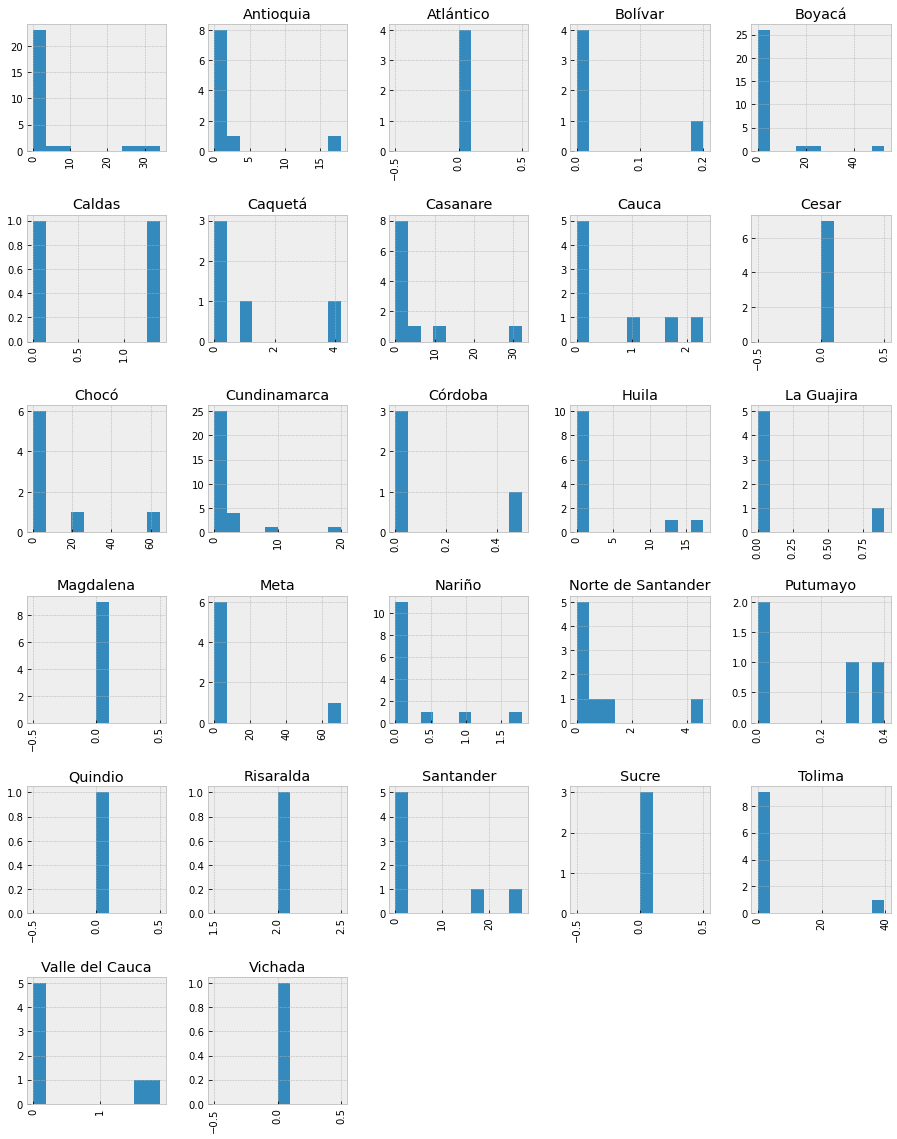

In [16]:
fig = plt.figure(figsize = (15,20))
ax3 = fig.gca()
estaciones.hist(ax = ax3, column='precipitacion', by = 'province')
plt.show()

In [17]:
estaciones.columns

Index(['station_name', 'municipality', 'province', 'id_stz', 'precipitacion',
       'the_geom', 'st_x', 'st_y'],
      dtype='object')

In [18]:
estaciones_gis = estaciones[['station_name', 'municipality', 'province', 'precipitacion', 'st_x', 'st_y']]
estaciones_gis

,station_name,municipality,province,precipitacion,st_x,st_y
0,PTE. ABADIA [35037100; MET; HID; LG; R; AO03; ...,Villavicencio,Meta,70.500,-73.636800,4.235520
1,PR CHOCO: BELLAVISTA [11080010; CHO; MET; SUB;...,Chocó,Chocó,64.600,-76.888100,6.556900
2,MONGUA [2403500084; BOY; MET; ST; N; AO06; H8;...,Mongua,Boyacá,52.800,-72.794850,5.758020
3,PIEDRAS DE COBRE [22057010; TOL; HID; LG; R; A...,Ortega,Tolima,39.700,-75.104611,3.910056
4,APTO OLAYA HERRERA [0027015330; ANT; MET; XX; ...,,,34.089,-75.588981,6.220611
...,...,...,...,...,...,...
237,PESCA [2403500083; BOY; MET; ST; N; AO06; H7; ...,Pesca,Boyacá,0.000,-73.076389,5.523611
238,PTE. TOTUMO [24037490; BOY; HID; ST; N; AO06; ...,Bonavita,Boyacá,0.000,-72.637940,6.437810
239,SAN SALVADOR [3602700101; CAS; HID; ST; N; AO0...,Hato Corozal,Casanare,0.000,-71.614722,6.227500
240,LA GRUTA [24037080; BOY; HID; ST; ROC; AO06; H...,Pesca,Boyacá,0.000,-73.046734,5.567045


In [21]:
estaciones_gis.to_excel(fr"C:\Users\easalazarm\Documents\IDEAM\IDEAM\Direccion General\Geopandas\Mapas estaciones automaticas\Tablas\precipitacion_24h.xls", index = False)

C:\Users\easalazarm\Anaconda3\envs\geo\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  """Entry point for launching an IPython kernel.


In [22]:
estaciones_gis['precipitacion'].sum()

1773.063